In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle
from gammapy.irf import load_cta_irfs
from gammapy.spectrum import SensitivityEstimator, CountsSpectrum

In [3]:
offset = Angle("0.5 deg")

energy_reco = np.logspace(-1.5, 2.0, 40) * u.TeV
energy_true = np.logspace(-1.5, 2.0, 200) * u.TeV

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
arf = irfs["aeff"].to_effective_area_table(offset, energy=energy_true)
rmf = irfs["edisp"].to_energy_dispersion(
    offset, e_true=energy_true, e_reco=energy_reco
)
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)

In [7]:
containment = 0.68
energy = np.sqrt(energy_reco[1:] * energy_reco[:-1])
on_radii = psf.containment_radius(energy=energy, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

In [8]:
arf.data.data *= containment

In [9]:
bkg_data = irfs["bkg"].evaluate_integrate(
    fov_lon=0 * u.deg, fov_lat=offset, energy_reco=energy_reco
)
bkg = CountsSpectrum(
    energy_reco[:-1],
    energy_reco[1:],
    data=(bkg_data * solid_angles).to_value("s-1"),
    unit="s-1",
)

In [66]:
sensitivity_estimator = SensitivityEstimator(
    arf=arf, rmf=rmf, bkg=bkg, livetime="200h", gamma_min=5, sigma=3, alpha=0.2
)
sensitivity_table = sensitivity_estimator.run()

In [67]:
sensitivity_table

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,str12
0.0350648,2.89079e-12,960.06,84971.2,significance
0.0431137,1.81543e-12,800.535,59027.8,significance
0.0530101,1.3947e-12,610.686,34294.3,significance
0.0651782,8.77937e-13,470.446,20310.1,significance
0.0801394,4.79598e-13,399.219,14602.2,significance
0.0985348,3.63667e-13,324.948,9651.09,significance
0.121153,3.11315e-13,261.829,6246.34,significance
0.148962,2.25215e-13,200.727,3653.14,significance


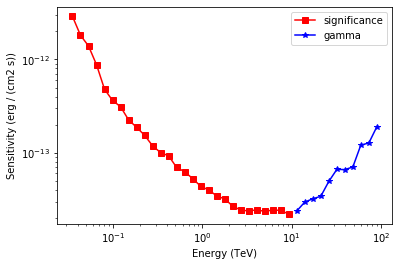

In [68]:
t = sensitivity_estimator.results_table

is_s = t["criterion"] == "significance"
plt.plot(
    t["energy"][is_s],
    t["e2dnde"][is_s],
    "s-",
    color="red",
    label="significance",
)

is_g = t["criterion"] == "gamma"
plt.plot(
    t["energy"][is_g], t["e2dnde"][is_g], "*-", color="blue", label="gamma"
)

plt.loglog()
plt.xlabel(f"Energy ({t['energy'].unit})")
plt.ylabel(f"Sensitivity ({t['e2dnde'].unit})")
plt.legend();

(0.01, 0.5)

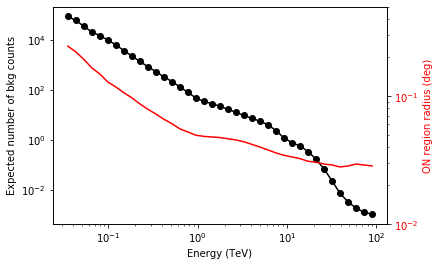

In [69]:
fig, ax1 = plt.subplots()
# ax1.plot( t["energy"], t["excess"],"o-", color="red", label="signal")
ax1.plot(
    t["energy"], t["background"], "o-", color="black", label="blackground"
)

ax1.loglog()
ax1.set_xlabel(f"Energy ({t['energy'].unit})")
ax1.set_ylabel("Expected number of bkg counts")

ax2 = ax1.twinx()
ax2.set_ylabel(f"ON region radius ({on_radii.unit})", color="red")
ax2.semilogy(t["energy"], on_radii, color="red", label="PSF68")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0.01, 0.5)